In [4]:
import os
from loomxpy.loomxpy import SCopeLoom
from pycisTopic.loom import *
from pycisTopic.pseudobulk_peak_calling import *
import glob
from pycisTopic.qc import *
import pybiomart as pbm
from fastkde import fastKDE
from pycisTopic.qc import plot_sample_metrics
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pycisTopic.cistopic_class import create_cistopic_object_from_fragments
from mycolorpy import colorlist as mcp
from pycisTopic.clust_vis import *
import seaborn as sns
from pycisTopic.iterative_peak_calling import *
import tempfile
import scrublet as scr


%matplotlib inline

In [5]:
def set_pandas_display_options():
    """Set pandas display options."""
    # Ref: https://stackoverflow.com/a/52432757/
    display = pd.options.display

    display.max_columns = 1000
    display.max_rows = 1000
    display.max_colwidth = 199
    display.width = 1000
    # display.precision = 2  # set as needed

set_pandas_display_options()

In [6]:
os.chdir("/staging/leuven/stg_00055/projects/adipose_project/")
projDir='/staging/leuven/stg_00055/projects/adipose_project/fragments/'
tmpDir = '/staging/leuven/stg_00055/projects/adipose_project/'
outDir = tmpDir + '/pycistopic/'
cistopic_out = outDir + 'quality_control/'

if not os.path.exists(outDir):
    os.makedirs(outDir)
if not os.path.exists(cistopic_out):
    os.makedirs(cistopic_out)

In [7]:
# Get TSS annotations for human (hg38)
dataset = pbm.Dataset(name='hsapiens_gene_ensembl',  host='http://www.ensembl.org')
annot = dataset.query(attributes=['chromosome_name', 'transcription_start_site', 'strand', 'external_gene_name', 'transcript_biotype'])
#filter = annot['Chromosome/scaffold name'].str.contains('CHR|GL|JH|MT')
filtered = annot['Chromosome/scaffold name'].str.contains('CHR|GL|JH|MT|KI')
annot = annot[~filtered]
annot['Chromosome/scaffold name'] = annot['Chromosome/scaffold name'].str.replace(r'(\b\S)', r'chr\1')
annot.columns=['Chromosome', 'Start', 'Strand', 'Gene', 'Transcript_type']
annot = annot[annot.Transcript_type == 'protein_coding']
annot

/tmp/ipykernel_13563/983919338.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  annot['Chromosome/scaffold name'] = annot['Chromosome/scaffold name'].str.replace(r'(\b\S)', r'chr\1')


,Chromosome,Start,Strand,Gene,Transcript_type
8053,chrY,22490397,1,PRY,protein_coding
8153,chrY,12662368,1,USP9Y,protein_coding
8155,chrY,12701231,1,USP9Y,protein_coding
8158,chrY,12847045,1,USP9Y,protein_coding
8328,chrY,22096007,-1,PRY2,protein_coding
...,...,...,...,...,...
246958,chr1,181483738,1,CACNA1E,protein_coding
246960,chr1,181732466,1,CACNA1E,protein_coding
246962,chr1,181776101,1,CACNA1E,protein_coding
246963,chr1,181793668,1,CACNA1E,protein_coding


In [8]:
target_url='http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.chrom.sizes'
chromsizes=pd.read_csv(target_url, sep='\t', header=None)
chromsizes.columns=['Chromosome', 'End']
chromsizes['Start']=[0]*chromsizes.shape[0]
chromsizes=chromsizes.loc[:,['Chromosome', 'Start', 'End']]
# Exceptionally in this case, to agree with CellRangerARC annotations
chromsizes['Chromosome'] = [chromsizes['Chromosome'][x].replace('v', '.') for x in range(len(chromsizes['Chromosome']))]
chromsizes['Chromosome'] = [chromsizes['Chromosome'][x].split('_')[1] if len(chromsizes['Chromosome'][x].split('_')) > 1 else chromsizes['Chromosome'][x] for x in range(len(chromsizes['Chromosome']))]
chromsizes=pr.PyRanges(chromsizes)

In [9]:
path_to_blacklist = '/staging/leuven/stg_00055/projects/ASAP/Multiome/CellRanger_gut/29062022_multiome/29-06-2022_ARC/SCREEN/hg38-blacklist.v2.bed'

In [33]:
filenames = glob.glob(projDir+'*.tsv.gz')
samples = [item.replace(projDir, "") for item in filenames]
samples= [item.replace("_fragments.tsv.gz","") for item in samples]
fragments_dict = {samples[i]: filenames[i] for i in range(len(samples))}
fragments_dict

{'pool1B': '/staging/leuven/stg_00055/projects/adipose_project/fragments/pool1B_fragments.tsv.gz',
 'pool1A': '/staging/leuven/stg_00055/projects/adipose_project/fragments/pool1A_fragments.tsv.gz'}

In [28]:
metadata= pd.read_table('adipose_RNA_meta.tsv', sep='\t', header=0, index_col=0)
metadata=metadata[['orig.ident','nCount_RNA','nFeature_RNA','percent.mt','percent.rb','S.Score','G2M.Score','Phase','RNA_snn_res.1','annotations']]
#colnames=[i[1:-1] for i in metadata.columns]
##metadata.columns=colnames
#indexnames=[i[1:-1] for i in metadata.index]
#metadata.index=indexnames
metadata['Pool']=metadata['orig.ident']
metadata.head()

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,percent.rb,S.Score,G2M.Score,Phase,RNA_snn_res.1,annotations,Pool
pool1A_AAACAGCCAACACTTG-1,pool1A,4069,1965,0.147456,0.221185,-0.006685,-0.014282,G1,14,adipocyte,pool1A
pool1A_AAACAGCCAACTCGCG-1,pool1A,2640,1398,0.265152,0.227273,0.045376,0.002085,S,17,adipocyte,pool1A
pool1A_AAACAGCCAATTAAGG-1,pool1A,2993,1670,0.400936,0.200468,0.009696,-0.029402,S,0,adipocyte,pool1A
pool1A_AAACAGCCAATTGACT-1,pool1A,756,534,0.264550,0.529101,-0.030877,-0.015532,G1,11,endothelial,pool1A
pool1A_AAACAGCCAATTTAGC-1,pool1A,4443,2179,0.225073,0.225073,0.031063,-0.017618,S,0,adipocyte,pool1A


In [34]:
#make barcode dictionary
barcode_dict={}
pools=metadata.Pool.unique().tolist()
for p in pools:
    pool_cells=metadata[metadata.Pool==p].index.tolist()
    pool_cells= list(map(lambda cell: cell.split('_')[1], pool_cells))
    barcode_dict[p]=pool_cells

In [61]:
barcode_dict.keys()

dict_keys(['pool1A', 'pool1B'])

In [59]:
def keep_BC(barcodes,fragments,outfile,pool):
    
    with tempfile.TemporaryDirectory(prefix='new_metadata') as td:
        fragments_unzip=os.path.join(td,'unzip_fragments.tsv')
        barcode_fragments=os.path.join(td,'barcode_fragments.tsv')
        #barcodes_unzip= os.path.join(td, 'unzip_barcodes.tsv')
        
        #!gzip -dc {barcodes}  > {barcodes_unzip}
        #!gzip -dc {fragments} | grep -v '#' > {fragments_unzip}
        #!gzip -dc {fragments} > {fragments_unzip}
        #!grep -v '#' {fragments_temp} > {fragments_unzip}
        print('Done unziping {0}...Load fragments and barcodes to pandas'.format(fragments))
        
        df = pd.read_csv(fragments,compression='gzip', sep='\t', header=None, skiprows=51)
        print(df.head())
        df.columns=['Chr','Start','End','CB','Counts']
        #dfb=pd.read_csv(barcodes_unzip, sep='\t', header=None)
        #dfb.columns=['CB']
        
        barcode_fragments = df[df.CB.isin(barcodes)]
        BC=barcode_fragments.iloc[:,3]
        BC=BC.to_list()
        new_BC=list(map(lambda cell: pool+'_'+cell, BC))
        barcode_fragments.iloc[:,3]=new_BC
        
        barcode_fragments.to_csv(outfile+'_BC_fragments.tsv', header=False,index=False, sep='\t')
    return()
    

In [60]:
for i in range(len(barcode_dict)):
    keep_BC(barcode_dict[list(barcode_dict.keys())[i]],
    fragments_dict[list(barcode_dict.keys())[i]],list(barcode_dict.keys())[i], list(barcode_dict.keys())[i] )
    

Done unziping /staging/leuven/stg_00055/projects/adipose_project/fragments/pool1A_fragments.tsv.gz...Load fragments and barcodes to pandas
      0      1      2                   3  4
0  chr1  10072  10278  TATGACTCACGAACAG-1  1
1  chr1  10073  10192  CGGCCATAGCTCATAA-1  1
2  chr1  10073  10197  AAAGGCTCAGAATGAC-1  1
3  chr1  10073  10210  TTACCGTGTTTGAGCA-1  1
4  chr1  10073  10277  AGGTCATTCAAGCTTA-1  3
Done unziping /staging/leuven/stg_00055/projects/adipose_project/fragments/pool1B_fragments.tsv.gz...Load fragments and barcodes to pandas
      0      1      2                   3  4
0  chr1  10072  10279  AAGGTATAGACTAAGG-1  2
1  chr1  10073  10204  TTGTTCCCAGCTACGT-1  1
2  chr1  10073  10210  CTTACCTCAATAGCCC-1  2
3  chr1  10073  10279  GAGCTAGCATAAGCAA-1  1
4  chr1  10073  10332  ATGGCCGGTTGCGCGA-1  1


In [63]:
filenames = glob.glob(tmpDir+'*_BC_fragments.tsv')
samples = [item.replace(tmpDir, "") for item in filenames]
samples= [item.replace("_BC_fragments.tsv","") for item in samples]
fragments_dict = {samples[i]: filenames[i] for i in range(len(samples))}
fragments_dict

{'pool1A': '/staging/leuven/stg_00055/projects/adipose_project/pool1A_BC_fragments.tsv',
 'pool1B': '/staging/leuven/stg_00055/projects/adipose_project/pool1B_BC_fragments.tsv'}

In [68]:
ray.shutdown()
bw_paths, bed_paths = export_pseudobulk(input_data = metadata,
                 variable = 'annotations',
                 sample_id_col = 'Pool',
                 chromsizes = chromsizes,
                 bed_path = outDir + 'consensus_peak_calling/pseudobulk_bed_files/',
                 bigwig_path = outDir + 'consensus_peak_calling/pseudobulk_bw_files/',
                 path_to_fragments = fragments_dict,
                 n_cpu = 2,
                 normalize_bigwig = True,
                 remove_duplicates = True,
                 _temp_dir = '/staging/leuven/stg_00055/' + 'ray_spill',
                 split_pattern = '-')


with open(outDir + '/consensus_peak_calling/pseudobulk_bed_files/bed_paths.pkl', 'wb') as f:
  pickle.dump(bed_paths, f)

with open(outDir + '/consensus_peak_calling/pseudobulk_bw_files/bigwig_paths.pkl', 'wb') as f:
  pickle.dump(bw_paths, f)

2023-01-09 09:38:00,283 cisTopic     INFO     Reading fragments from /staging/leuven/stg_00055/projects/adipose_project/pool1A_BC_fragments.tsv
2023-01-09 09:38:45,915 cisTopic     INFO     Reading fragments from /staging/leuven/stg_00055/projects/adipose_project/pool1B_BC_fragments.tsv


2023-01-09 09:39:35,437	INFO worker.py:1519 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


(export_pseudobulk_ray pid=8413) 2023-01-09 09:39:41,250 cisTopic     INFO     Creating pseudobulk for ASPC
(export_pseudobulk_ray pid=8412) 2023-01-09 09:39:41,206 cisTopic     INFO     Creating pseudobulk for Cluster_16


(export_pseudobulk_ray pid=8412) /data/leuven/343/vsc34389/jupyter/envs/pycisTopic/lib/python3.9/site-packages/pycisTopic/pseudobulk_peak_calling.py:273: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
(export_pseudobulk_ray pid=8412)   group_fragments = group_fragments_list[0].append(group_fragments_list[1:])
(export_pseudobulk_ray pid=8413) /data/leuven/343/vsc34389/jupyter/envs/pycisTopic/lib/python3.9/site-packages/pycisTopic/pseudobulk_peak_calling.py:273: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
(export_pseudobulk_ray pid=8413)   group_fragments = group_fragments_list[0].append(group_fragments_list[1:])


(export_pseudobulk_ray pid=8412) 2023-01-09 09:40:29,085 cisTopic     INFO     Cluster_16 done!
(export_pseudobulk_ray pid=8412) 2023-01-09 09:40:29,142 cisTopic     INFO     Creating pseudobulk for Cluster_25


(export_pseudobulk_ray pid=8412) /data/leuven/343/vsc34389/jupyter/envs/pycisTopic/lib/python3.9/site-packages/pycisTopic/pseudobulk_peak_calling.py:273: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
(export_pseudobulk_ray pid=8412)   group_fragments = group_fragments_list[0].append(group_fragments_list[1:])


(export_pseudobulk_ray pid=8412) 2023-01-09 09:40:47,895 cisTopic     INFO     Cluster_25 done!
(export_pseudobulk_ray pid=8412) 2023-01-09 09:40:47,939 cisTopic     INFO     Creating pseudobulk for Immune


(export_pseudobulk_ray pid=8412) /data/leuven/343/vsc34389/jupyter/envs/pycisTopic/lib/python3.9/site-packages/pycisTopic/pseudobulk_peak_calling.py:273: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
(export_pseudobulk_ray pid=8412)   group_fragments = group_fragments_list[0].append(group_fragments_list[1:])


(export_pseudobulk_ray pid=8413) 2023-01-09 09:43:21,116 cisTopic     INFO     ASPC done!
(export_pseudobulk_ray pid=8413) 2023-01-09 09:43:21,235 cisTopic     INFO     Creating pseudobulk for LEC


(export_pseudobulk_ray pid=8413) /data/leuven/343/vsc34389/jupyter/envs/pycisTopic/lib/python3.9/site-packages/pycisTopic/pseudobulk_peak_calling.py:273: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
(export_pseudobulk_ray pid=8413)   group_fragments = group_fragments_list[0].append(group_fragments_list[1:])


(export_pseudobulk_ray pid=8412) 2023-01-09 09:43:45,909 cisTopic     INFO     Immune done!
(export_pseudobulk_ray pid=8412) 2023-01-09 09:43:46,003 cisTopic     INFO     Creating pseudobulk for SMC


(export_pseudobulk_ray pid=8412) /data/leuven/343/vsc34389/jupyter/envs/pycisTopic/lib/python3.9/site-packages/pycisTopic/pseudobulk_peak_calling.py:273: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
(export_pseudobulk_ray pid=8412)   group_fragments = group_fragments_list[0].append(group_fragments_list[1:])


(export_pseudobulk_ray pid=8412) 2023-01-09 09:44:34,535 cisTopic     INFO     SMC done!
(export_pseudobulk_ray pid=8412) 2023-01-09 09:44:34,640 cisTopic     INFO     Creating pseudobulk for adipocyte


(export_pseudobulk_ray pid=8412) /data/leuven/343/vsc34389/jupyter/envs/pycisTopic/lib/python3.9/site-packages/pycisTopic/pseudobulk_peak_calling.py:273: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
(export_pseudobulk_ray pid=8412)   group_fragments = group_fragments_list[0].append(group_fragments_list[1:])


(export_pseudobulk_ray pid=8413) 2023-01-09 09:45:49,751 cisTopic     INFO     LEC done!
(export_pseudobulk_ray pid=8413) 2023-01-09 09:45:49,833 cisTopic     INFO     Creating pseudobulk for endothelial


(export_pseudobulk_ray pid=8413) /data/leuven/343/vsc34389/jupyter/envs/pycisTopic/lib/python3.9/site-packages/pycisTopic/pseudobulk_peak_calling.py:273: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
(export_pseudobulk_ray pid=8413)   group_fragments = group_fragments_list[0].append(group_fragments_list[1:])


(export_pseudobulk_ray pid=8413) 2023-01-09 09:48:50,752 cisTopic     INFO     endothelial done!
(export_pseudobulk_ray pid=8413) 2023-01-09 09:48:50,834 cisTopic     INFO     Creating pseudobulk for macrophage


(export_pseudobulk_ray pid=8413) /data/leuven/343/vsc34389/jupyter/envs/pycisTopic/lib/python3.9/site-packages/pycisTopic/pseudobulk_peak_calling.py:273: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
(export_pseudobulk_ray pid=8413)   group_fragments = group_fragments_list[0].append(group_fragments_list[1:])


(export_pseudobulk_ray pid=8413) 2023-01-09 09:53:21,433 cisTopic     INFO     macrophage done!
(export_pseudobulk_ray pid=8413) 2023-01-09 09:53:21,552 cisTopic     INFO     Creating pseudobulk for mastcells


(export_pseudobulk_ray pid=8413) /data/leuven/343/vsc34389/jupyter/envs/pycisTopic/lib/python3.9/site-packages/pycisTopic/pseudobulk_peak_calling.py:273: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
(export_pseudobulk_ray pid=8413)   group_fragments = group_fragments_list[0].append(group_fragments_list[1:])


(export_pseudobulk_ray pid=8413) 2023-01-09 09:53:37,728 cisTopic     INFO     mastcells done!
(export_pseudobulk_ray pid=8413) 2023-01-09 09:53:37,776 cisTopic     INFO     Creating pseudobulk for mesothelium


(export_pseudobulk_ray pid=8413) /data/leuven/343/vsc34389/jupyter/envs/pycisTopic/lib/python3.9/site-packages/pycisTopic/pseudobulk_peak_calling.py:273: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
(export_pseudobulk_ray pid=8413)   group_fragments = group_fragments_list[0].append(group_fragments_list[1:])


(export_pseudobulk_ray pid=8413) 2023-01-09 09:55:22,719 cisTopic     INFO     mesothelium done!
(export_pseudobulk_ray pid=8413) 2023-01-09 09:55:22,786 cisTopic     INFO     Creating pseudobulk for pericyte


(export_pseudobulk_ray pid=8413) /data/leuven/343/vsc34389/jupyter/envs/pycisTopic/lib/python3.9/site-packages/pycisTopic/pseudobulk_peak_calling.py:273: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
(export_pseudobulk_ray pid=8413)   group_fragments = group_fragments_list[0].append(group_fragments_list[1:])


(export_pseudobulk_ray pid=8413) 2023-01-09 09:56:39,211 cisTopic     INFO     pericyte done!
(export_pseudobulk_ray pid=8412) 2023-01-09 10:03:43,793 cisTopic     INFO     adipocyte done!


In [71]:
ray.shutdown()
# Set correct path to run MACS2

macs_path='/data/leuven/343/vsc34389/jupyter/bin/macs2'
outdir = '/staging/leuven/stg_00055/projects/adipose_project/pycistopic/consensus_peak_calling/MACS/'

# Run peak calling
narrow_peaks_dict = peak_calling(macs_path, bed_paths, 
                                 outdir, 
                                 genome_size='hs',
                                 n_cpu=6, 
                                 input_format='BEDPE', 
                                 shift=-73, 
                                 ext_size=146, 
                                 keep_dup = 'all', 
                                 q_value = 0.05)

2023-01-09 10:15:00,875	INFO worker.py:1519 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


(macs_call_peak_ray pid=24695) 2023-01-09 10:15:07,923 cisTopic     INFO     Calling peaks for SMC with /data/leuven/343/vsc34389/jupyter/bin/macs2 callpeak --treatment /staging/leuven/stg_00055/projects/adipose_project//pycistopic/consensus_peak_calling/pseudobulk_bed_files/SMC.bed.gz --name SMC  --outdir /staging/leuven/stg_00055/projects/adipose_project/pycistopic/consensus_peak_calling/MACS/ --format BEDPE --gsize hs --qvalue 0.05 --nomodel --shift -73 --extsize 146 --keep-dup all --call-summits --nolambda
(macs_call_peak_ray pid=24693) 2023-01-09 10:15:07,924 cisTopic     INFO     Calling peaks for LEC with /data/leuven/343/vsc34389/jupyter/bin/macs2 callpeak --treatment /staging/leuven/stg_00055/projects/adipose_project//pycistopic/consensus_peak_calling/pseudobulk_bed_files/LEC.bed.gz --name LEC  --outdir /staging/leuven/stg_00055/projects/adipose_project/pycistopic/consensus_peak_calling/MACS/ --format BEDPE --gsize hs --qvalue 0.05 --nomodel --shift -73 --extsize 146 --keep-du

In [72]:
with open('/staging/leuven/stg_00055/projects/adipose_project/pycistopic/consensus_peak_calling/MACS/narrow_peaks_dict.pkl', 'wb') as f:
  pickle.dump(narrow_peaks_dict, f)

In [75]:
# Other param
peak_half_width=250
# Get consensus peaks
consensus_peaks=get_consensus_peaks(narrow_peaks_dict, peak_half_width, chromsizes=chromsizes, path_to_blacklist=path_to_blacklist) 

2023-01-09 10:29:12,308 cisTopic     INFO     Extending and merging peaks per class
2023-01-09 10:30:43,890 cisTopic     INFO     Normalizing peak scores
2023-01-09 10:30:44,258 cisTopic     INFO     Merging peaks
Warning! Start and End columns now have different dtypes: int64 and int32
2023-01-09 10:32:01,923 cisTopic     INFO     Done!


In [76]:
consensus_peaks.to_bed(path= outDir + 'consensus_peak_calling/consensus_regions.bed', keep=True, compression='infer', chain=False)

/data/leuven/343/vsc34389/jupyter/envs/pycisTopic/lib/python3.9/site-packages/pyranges/out.py:37: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return pd.concat([outdf, df.get(noncanonical)], axis=1)
/data/leuven/343/vsc34389/jupyter/envs/pycisTopic/lib/python3.9/site-packages/pyranges/out.py:37: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return pd.concat([outdf, df.get(noncanonical)], axis=1)
/data/leuven/343/vsc34389/jupyter/envs/pycisTopic/lib/python3.9/site-packages/pyranges/out.py:37: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return pd.concat([outdf, df.get(noncanonical)], axis=1)
/data/leuven/343/vsc34389/jupyter/envs/pycisTopic/lib/python3.9/site-packages/pyranges/out.py:37: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Us

In [77]:
regions = outDir + 'consensus_peak_calling/consensus_regions.bed'
regionslist = [regions] * len(fragments_dict)
path_to_regions = {samples[i]: regionslist[i] for i in range(len(samples))}
path_to_regions

{'pool1A': '/staging/leuven/stg_00055/projects/adipose_project//pycistopic/consensus_peak_calling/consensus_regions.bed',
 'pool1B': '/staging/leuven/stg_00055/projects/adipose_project//pycistopic/consensus_peak_calling/consensus_regions.bed'}

In [78]:
ray.shutdown()
metadata_bc_dict, profile_data_dict = compute_qc_stats(fragments_dict = fragments_dict,
                tss_annotation = annot,
                stats=['barcode_rank_plot', 'duplicate_rate', 'insert_size_distribution', 'profile_tss', 'frip'],
                label_list = None,
                path_to_regions = path_to_regions,
                n_cpu = 2,
                valid_bc = None,
                n_frag = 10,
                n_bc = None,
                tss_flank_window = 2000,
                tss_window = 50,
                tss_minimum_signal_window = 100,
                tss_rolling_window = 10,
                # min_norm=0.2,
                remove_duplicates = True)

2023-01-09 10:43:36,517	INFO worker.py:1519 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


(compute_qc_stats_ray pid=409) 2023-01-09 10:43:41,711 cisTopic     INFO     Reading pool1B
(compute_qc_stats_ray pid=410) 2023-01-09 10:43:41,712 cisTopic     INFO     Reading pool1A
(compute_qc_stats_ray pid=409) 2023-01-09 10:44:33,157 cisTopic     INFO     Computing barcode rank plot for pool1B
(compute_qc_stats_ray pid=409) 2023-01-09 10:44:33,157 cisTopic     INFO     Counting fragments
(compute_qc_stats_ray pid=409) 2023-01-09 10:44:35,992 cisTopic     INFO     Marking barcodes with more than 10
(compute_qc_stats_ray pid=409) 2023-01-09 10:44:35,994 cisTopic     INFO     Returning plot data
(compute_qc_stats_ray pid=409) 2023-01-09 10:44:35,995 cisTopic     INFO     Returning valid barcodes
(compute_qc_stats_ray pid=410) 2023-01-09 10:44:37,994 cisTopic     INFO     Computing barcode rank plot for pool1A
(compute_qc_stats_ray pid=410) 2023-01-09 10:44:37,994 cisTopic     INFO     Counting fragments
(compute_qc_stats_ray pid=410) 2023-01-09 10:44:40,494 cisTopic     INFO     Mark

/data/leuven/343/vsc34389/jupyter/envs/pycisTopic/lib/python3.9/site-packages/pycisTopic/qc.py:1618: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(
/data/leuven/343/vsc34389/jupyter/envs/pycisTopic/lib/python3.9/site-packages/pycisTopic/qc.py:1618: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

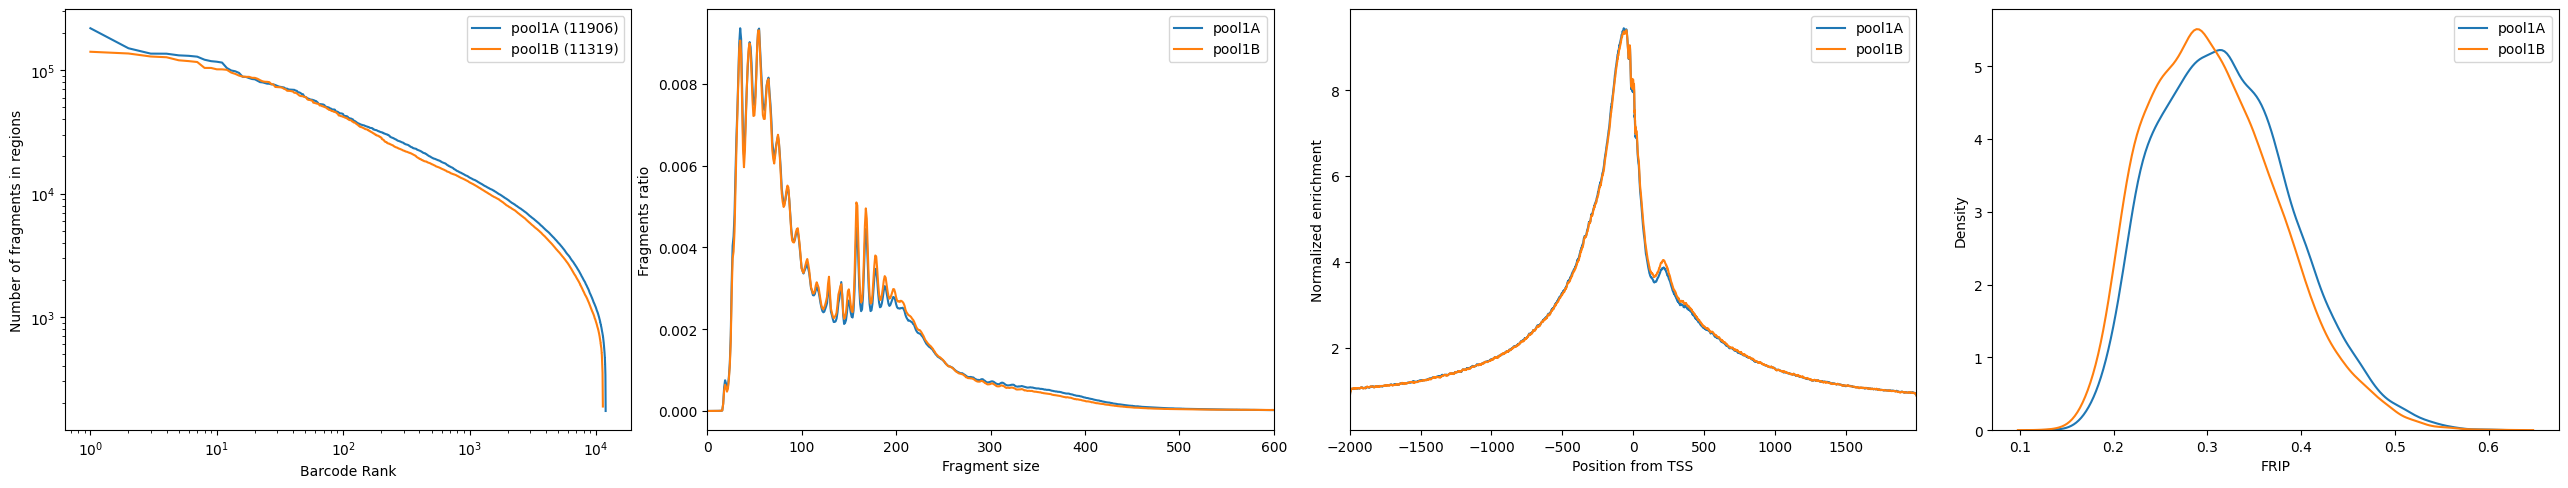

In [79]:
plot_sample_metrics(
           profile_data_dict,
           profile_list=['barcode_rank_plot', 'insert_size_distribution', 'profile_tss', 'frip'],
           insert_size_distribution_xlim=[0,600],
           #legend_outside=True,
           ncol=4,
           cmap='Paired',
           plot=True,
           save=cistopic_out + 'sample_metrics.pdf')

In [88]:
frags_lower = [2000, 2000]
tss_lower = [4, 4]
frip_lower=[0.2,0.2]
filenames = glob.glob(tmpDir+'*_BC_fragments.tsv')
filter_frags_lower = {samples[i]: frags_lower[i] for i in range(len(samples))}
filter_tss_lower = {samples[i]: tss_lower[i] for i in range(len(samples))}
filter_frip_lower = {samples[i]: frip_lower[i] for i in range(len(samples))}

In [83]:
def plot_frag_qc(x, y, 
                 ax,
                 x_thr_min=None, x_thr_max=None,
                 y_thr_min=None, y_thr_max=None,
                 ylab=None,
                 xlab="Number of (unique) fragments",
                 cmap='viridis',
                 density_overlay=False,
                 s=10,
                 marker='+',
                 c='#343434',
                 xlim=None,
                 ylim=None,
                 **kwargs
                ):
    assert all(x.index == y.index)
    barcodes = x.index.values
    if density_overlay:
        pdf,axes = fastKDE.pdf(x.to_numpy(),y.to_numpy())
        xy = np.vstack([np.log(x),y])
        z = gaussian_kde(xy)(xy)
        idx = z.argsort()
        x, y, z, barcodes = x[idx], y[idx], z[idx], barcodes[idx]
    else:
        z=c
    barcodes_to_keep=[]
    sp=ax.scatter(x, y, c=z, s=s, edgecolors=None, marker=marker, cmap=cmap, **kwargs)
    #fig.colorbar(sp)
    if ylim is not None:
        ax.set_ylim(ylim[0], ylim[1])
    if xlim is not None:
        ax.set_xlim(xlim[0], xlim[1])
    # thresholds:
    if x_thr_min is not None:    
        ax.axvline(x=x_thr_min, color='r', linestyle='--')
        barcodes_to_keep.append(barcodes[x>x_thr_min])
    if x_thr_max is not None:    
        ax.axvline(x=x_thr_max, color='r', linestyle='--')
        barcodes_to_keep.append(barcodes[x<x_thr_max])
    if y_thr_min is not None:    
        ax.axhline(y=y_thr_min, color='r', linestyle='--')
        barcodes_to_keep.append(barcodes[y>y_thr_min])
    if y_thr_max is not None:    
        ax.axhline(y=y_thr_max, color='r', linestyle='--')
        barcodes_to_keep.append(barcodes[y<y_thr_max])
    ax.set_xscale("log")
    ax.set_xmargin(0.01)
    ax.set_ymargin(0.01)
    ax.set_xlabel(xlab,fontsize=10)
    ax.set_ylabel(ylab,fontsize=10)
    #ax.colorbar().set_label('Density')
    #return barcodes_to_keep
    if len(barcodes_to_keep)>0:
        return list(set.intersection(*map(set, barcodes_to_keep)))
    else:
        return barcodes


/tmp/ipykernel_13563/1657971219.py:27: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sp=ax.scatter(x, y, c=z, s=s, edgecolors=None, marker=marker, cmap=cmap, **kwargs)
/tmp/ipykernel_13563/1657971219.py:27: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sp=ax.scatter(x, y, c=z, s=s, edgecolors=None, marker=marker, cmap=cmap, **kwargs)


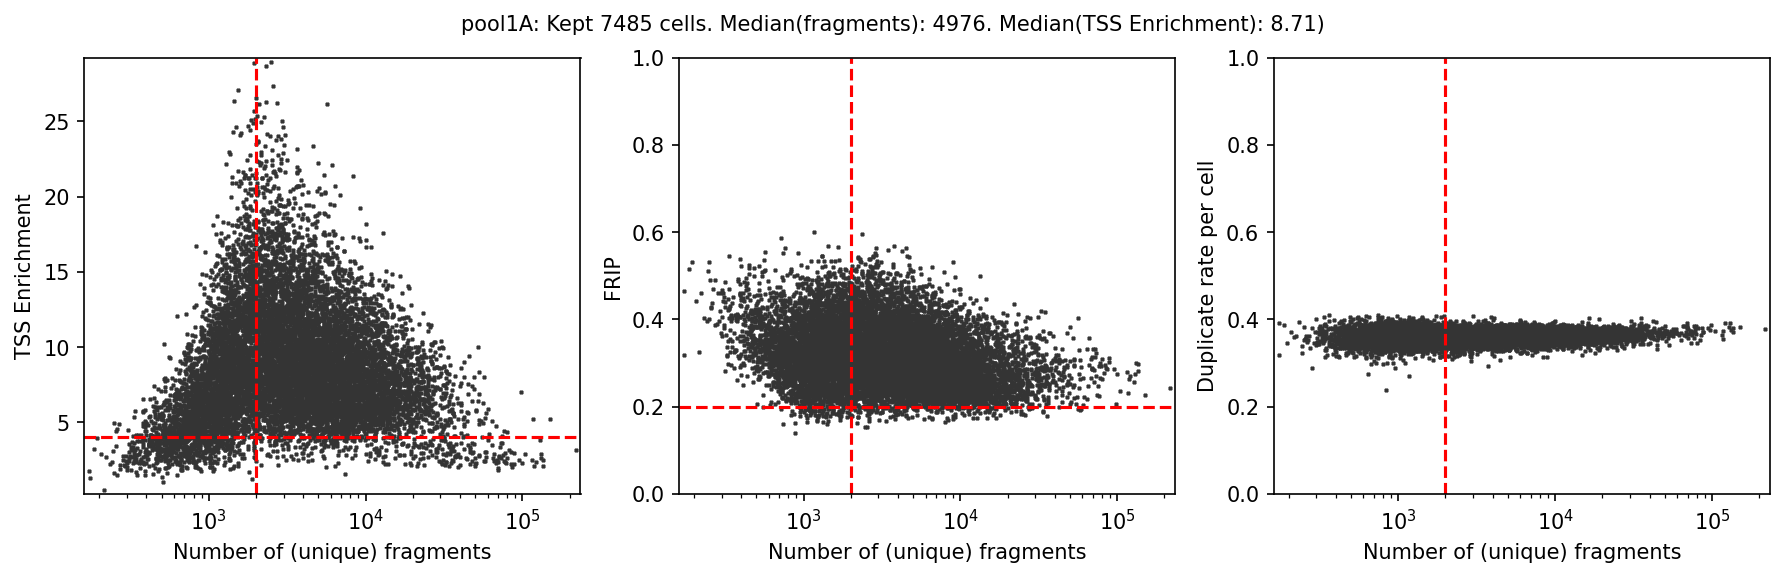

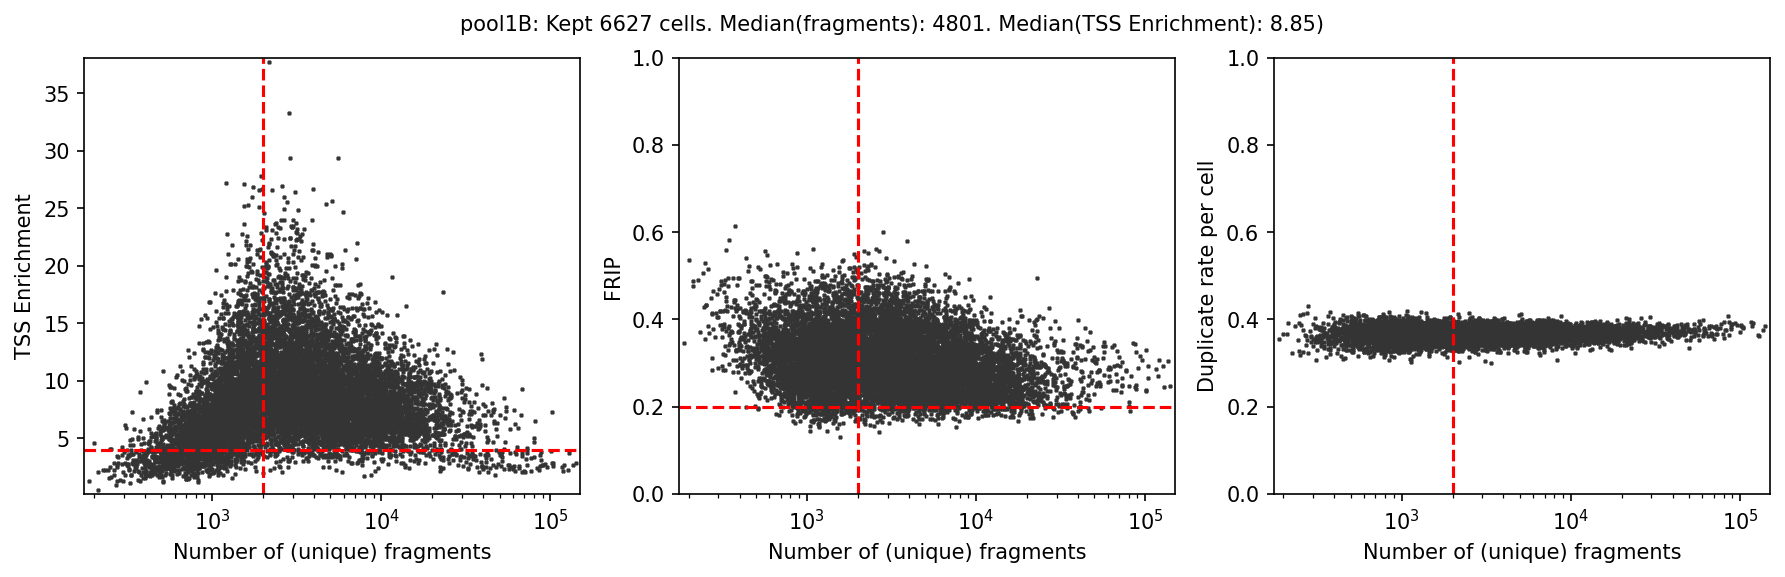

In [89]:
include_kde = False # set to False for faster draft-quality plots
detailed_title=True
s=4
bc_passing_filters = {}
for k,v in metadata_bc_dict.items():
    fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(12,4), dpi=150 )
    p1_cells = plot_frag_qc(
        x = metadata_bc_dict[k]['Unique_nr_frag'],
        y = metadata_bc_dict[k]['TSS_enrichment'],
        ylab = 'TSS Enrichment',
        s=s,
        x_thr_min=filter_frags_lower[k],
        y_thr_min=filter_tss_lower[k],
        density_overlay=include_kde,
        ax=ax1
    )
    p2_cells = plot_frag_qc(
        x = metadata_bc_dict[k]['Unique_nr_frag'],
        y = metadata_bc_dict[k]['FRIP'],
        x_thr_min=filter_frags_lower[k],
        y_thr_min=filter_frip_lower[k],
        ylab = 'FRIP',
        s=s,
        ylim=[0,1],
        density_overlay=include_kde,
        ax=ax2
    )
    p3_cells = plot_frag_qc(
        x = metadata_bc_dict[k]['Unique_nr_frag'],
        y = metadata_bc_dict[k]['Dupl_rate'],
        x_thr_min=filter_frags_lower[k],
        ylab = 'Duplicate rate per cell',
        s=s,
        ylim=[0,1],
        density_overlay=include_kde,
        ax=ax3
    )
    bc_passing_filters[k] = list(set(p1_cells) & set(p2_cells) & set(p3_cells))
    if detailed_title:
        med_nf = metadata_bc_dict[k].loc[bc_passing_filters[k],'Unique_nr_frag'].median()
        med_tss = metadata_bc_dict[k].loc[bc_passing_filters[k],'TSS_enrichment'].median()
        title = f"{k}: Kept {len(bc_passing_filters[k])} cells. Median(fragments): {med_nf:.0f}. Median(TSS Enrichment): {med_tss:.2f})"
    else:
        title = k
    fig.suptitle(title, x=0.5, y=0.95, fontsize=10)
    plt.tight_layout()
    plt.savefig(cistopic_out + k + ".png", bbox_inches = "tight", transparent=False, facecolor='w', edgecolor='w', dpi=150)

In [90]:
with open(cistopic_out + 'bc_passing_filters.pkl', 'wb') as f:
  pickle.dump(bc_passing_filters, f)

In [91]:
fragments_dict.keys() == fragments_dict.keys() == path_to_regions.keys() == metadata_bc_dict.keys()

True

In [92]:
#Create all objects
cistopic_obj_dict={key:create_cistopic_object_from_fragments(path_to_fragments=fragments_dict[key],
                                               path_to_regions=path_to_regions[key],
                                               path_to_blacklist=path_to_blacklist,
                                               metrics=metadata_bc_dict[key],
                                               valid_bc=bc_passing_filters[key],
                                               n_cpu=2,
                                               project=key) for key in fragments_dict.keys()}

cistopic_obj_list=list(cistopic_obj_dict.values())

2023-01-09 10:59:50,859 cisTopic     INFO     Reading data for pool1A
2023-01-09 11:00:35,409 cisTopic     INFO     metrics provided!
2023-01-09 11:00:38,327 cisTopic     INFO     valid_bc provided, selecting barcodes!
2023-01-09 11:00:40,815 cisTopic     INFO     Counting fragments in regions


2023-01-09 11:00:45,180	INFO worker.py:1519 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


2023-01-09 11:01:00,815 cisTopic     INFO     Creating fragment matrix


/data/leuven/343/vsc34389/jupyter/envs/pycisTopic/lib/python3.9/site-packages/pycisTopic/cistopic_class.py:881: PerformanceWarning: The following operation may generate 2482228095 cells in the resulting pandas object.
  counts_df.groupby(["Name", "regionID"], sort=False, observed=True)


2023-01-09 11:01:29,725 cisTopic     INFO     Converting fragment matrix to sparse matrix
2023-01-09 11:01:42,722 cisTopic     INFO     Removing blacklisted regions
2023-01-09 11:01:44,052 cisTopic     INFO     Creating CistopicObject
2023-01-09 11:01:45,093 cisTopic     INFO     Done!
2023-01-09 11:01:45,357 cisTopic     INFO     Reading data for pool1B
2023-01-09 11:02:23,656 cisTopic     INFO     metrics provided!
2023-01-09 11:02:26,393 cisTopic     INFO     valid_bc provided, selecting barcodes!
2023-01-09 11:02:28,839 cisTopic     INFO     Counting fragments in regions


2023-01-09 11:02:34,133	INFO worker.py:1519 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


2023-01-09 11:02:47,462 cisTopic     INFO     Creating fragment matrix


/data/leuven/343/vsc34389/jupyter/envs/pycisTopic/lib/python3.9/site-packages/pycisTopic/cistopic_class.py:881: PerformanceWarning: The following operation may generate 2197645740 cells in the resulting pandas object.
  counts_df.groupby(["Name", "regionID"], sort=False, observed=True)


2023-01-09 11:03:17,406 cisTopic     INFO     Converting fragment matrix to sparse matrix
2023-01-09 11:03:29,668 cisTopic     INFO     Removing blacklisted regions
2023-01-09 11:03:30,957 cisTopic     INFO     Creating CistopicObject
2023-01-09 11:03:31,921 cisTopic     INFO     Done!


In [93]:
cistopicobjpath = cistopic_out + 'cistopicobj/' 
cistopicobjname = cistopicobjpath+'cistopicobj_list.pkl'

objectDir=cistopicobjpath
if not os.path.exists(objectDir):
    os.makedirs(objectDir)

with open(cistopicobjname, 'wb') as f:
    pickle.dump(cistopic_obj_list, f)

In [95]:
cistopic_obj_list

In [94]:
cistopic_obj = merge(cistopic_obj_list)

2023-01-09 11:05:35,117 cisTopic     INFO     cisTopic object 1 merged


In [96]:
print(cistopic_obj)

CistopicObject from project cisTopic_merge with n_cells × n_regions = 14112 × 331629


In [97]:
scrub = scr.Scrublet(cistopic_obj.fragment_matrix.T, expected_doublet_rate=0.1)
doublet_scores, predicted_doublets = scrub.scrub_doublets()
scrub.call_doublets(threshold=0.3)
scrublet = pd.DataFrame([scrub.doublet_scores_obs_, scrub.predicted_doublets_], columns=cistopic_obj.cell_names, index=['Doublet_scores_fragments', 'Predicted_doublets_fragments']).T

Preprocessing...


/data/leuven/343/vsc34389/jupyter/envs/pycisTopic/lib/python3.9/site-packages/scrublet/helper_functions.py:252: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.04
Detected doublet rate = 99.5%
Estimated detectable doublet fraction = 99.6%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 99.9%
Elapsed time: 67.6 seconds
Detected doublet rate = 6.1%
Estimated detectable doublet fraction = 16.7%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 36.6%


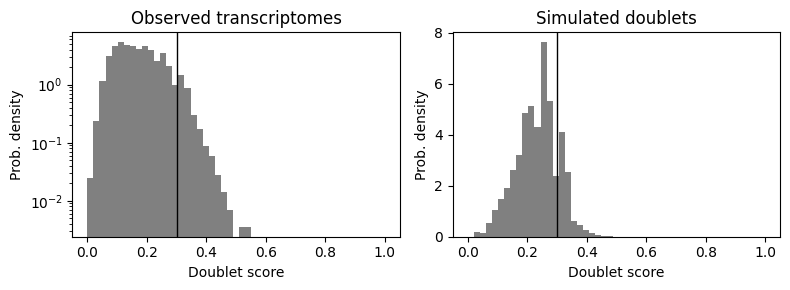

In [98]:
scrub.plot_histogram();

In [99]:
cistopic_obj.add_cell_data(scrublet)
sum(cistopic_obj.cell_data.Predicted_doublets_fragments == True)

863

In [104]:
scrublet

,Doublet_scores_fragments,Predicted_doublets_fragments
pool1A_TCACATAAGCTTACTT-1___pool1A,0.37788,True
pool1A_CCGTTGCGTGATTTGG-1___pool1A,0.346154,True
pool1A_CCTAAGTAGTCATTTC-1___pool1A,0.197297,False
pool1A_AGGCTAAAGGAGCAAC-1___pool1A,0.294776,False
pool1A_TATTAGCCATCCGTAA-1___pool1A,0.294776,False
...,...,...
pool1B_GAGCTTGTCTAATCAG-1___pool1B,0.07962,False
pool1B_CACTTAAAGTAAGTCC-1___pool1B,0.083146,False
pool1B_GCAATCTAGGACCTCA-1___pool1B,0.099249,False
pool1B_AGCATTTCAATCGCAC-1___pool1B,0.062982,False


In [100]:
# Remove doublets 
singlets = cistopic_obj.cell_data[cistopic_obj.cell_data.Predicted_doublets_fragments == False].index.tolist()
# Subset cisTopic object
cistopic_obj_noDBL = cistopic_obj.subset(singlets, copy=True)
print(cistopic_obj_noDBL)

CistopicObject from project cisTopic_merge with n_cells × n_regions = 13249 × 331629


In [101]:
cistopicobjpath = cistopic_out + 'cistopicobj/' 
cistopicobjname = cistopicobjpath+'cistopicobj_merged_nodoubl0.3.pkl'

objectDir=cistopicobjpath
with open(cistopicobjname, 'wb') as f:
  pickle.dump(cistopic_obj_noDBL, f)

In [115]:
metadata['CB']=metadata.index
metadata.head()

In [122]:
cistopic_obj.cell_data.tail()

,barcode,Doublet_scores_fragments,cisTopic_nr_acc,Log_total_nr_frag,Dupl_rate,sample_id,Predicted_doublets_fragments,TSS_enrichment,FRIP,Dupl_nr_frag,cisTopic_log_nr_frag,Log_unique_nr_frag,cisTopic_log_nr_acc,cisTopic_nr_frag,Total_nr_frag_in_regions,Unique_nr_frag_in_regions,Unique_nr_frag,Total_nr_frag,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,percent.rb,S.Score,G2M.Score,Phase,RNA_snn_res.1,annotations,Pool,CB
pool1B_GAGCTTGTCTAATCAG-1___pool1B,pool1B_GAGCTTGTCTAATCAG-1,0.07962,660,3.697142,0.361719,pool1B,False,6.233731,0.200755,1801,2.828015,3.502154,2.819544,673,1060,638,3178,4979,pool1B,845,668,0.355030,0.828402,0.013980,-0.033982,S,13,endothelial,pool1B,pool1B_GAGCTTGTCTAATCAG-1
pool1B_CACTTAAAGTAAGTCC-1___pool1B,pool1B_CACTTAAAGTAAGTCC-1,0.083146,613,3.652343,0.376086,pool1B,False,9.420048,0.216274,1689,2.802089,3.447468,2.78746,634,940,606,2802,4491,pool1B,2155,1326,0.046404,0.278422,-0.043290,-0.024645,G1,5,macrophage,pool1B,pool1B_CACTTAAAGTAAGTCC-1
pool1B_GCAATCTAGGACCTCA-1___pool1B,pool1B_GCAATCTAGGACCTCA-1,0.099249,768,3.631241,0.370266,pool1B,False,5.672226,0.269859,1584,2.887617,3.430398,2.885361,772,1204,727,2694,4278,pool1B,1603,1178,0.623830,0.249532,-0.041969,-0.049351,G1,6,Immune,pool1B,pool1B_GCAATCTAGGACCTCA-1
pool1B_AGCATTTCAATCGCAC-1___pool1B,pool1B_AGCATTTCAATCGCAC-1,0.062982,654,3.537945,0.354680,pool1B,False,6.123709,0.286035,1224,2.823474,3.347720,2.815578,666,1033,637,2227,3451,pool1B,1093,697,0.000000,0.000000,-0.022317,-0.021578,G1,1,ASPC,pool1B,pool1B_AGCATTTCAATCGCAC-1
pool1B_CTGGTTTGTAACGTGC-1___pool1B,pool1B_CTGGTTTGTAACGTGC-1,0.060377,667,3.621176,0.370574,pool1B,False,8.257061,0.245914,1549,2.83187,3.420121,2.824126,679,1038,647,2631,4180,pool1B,1310,938,0.534351,0.534351,0.049762,0.003535,S,13,endothelial,pool1B,pool1B_CTGGTTTGTAACGTGC-1


In [140]:
a=[]
for i in cistopic_obj.cell_data.annotations:
    if i =='adipocyte':
        a.append('adipocyte')
    else:
        a.append('non-adipocyte')

cistopic_obj.cell_data['Type']=a      

In [118]:
cistopic_obj.add_cell_data(metadata)

Columns ['S.Score', 'percent.rb', 'G2M.Score', 'nFeature_RNA', 'orig.ident', 'nCount_RNA', 'Phase', 'percent.mt', 'annotations', 'RNA_snn_res.1', 'Pool'] will be overwritten


In [111]:
cistopic_obj.cell_data.columns

Index(['cisTopic_nr_frag', 'cisTopic_log_nr_frag', 'cisTopic_nr_acc', 'cisTopic_log_nr_acc', 'sample_id', 'Log_total_nr_frag', 'Log_unique_nr_frag', 'Total_nr_frag', 'Unique_nr_frag', 'Dupl_nr_frag', 'Dupl_rate', 'Total_nr_frag_in_regions', 'Unique_nr_frag_in_regions', 'FRIP', 'TSS_enrichment', 'barcode', 'Doublet_scores_fragments', 'Predicted_doublets_fragments', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'percent.rb', 'S.Score', 'G2M.Score', 'Phase', 'RNA_snn_res.1', 'annotations', 'Pool'], dtype='object')

In [141]:
cistopic_obj.cell_data.loc['pool1A_CCTAAGTAGTCATTTC-1___pool1A',:]

barcode                         pool1A_CCTAAGTAGTCATTTC-1
Doublet_scores_fragments                         0.197297
cisTopic_nr_acc                                      1969
Log_total_nr_frag                                4.086111
Dupl_rate                                        0.359551
sample_id                                          pool1A
Predicted_doublets_fragments                        False
TSS_enrichment                                   5.974594
FRIP                                             0.246126
Dupl_nr_frag                                         4384
cisTopic_log_nr_frag                              3.30103
Log_unique_nr_frag                               3.892595
cisTopic_log_nr_acc                              3.294246
cisTopic_nr_frag                                     2000
Total_nr_frag_in_regions                             3084
Unique_nr_frag_in_regions                            1922
Unique_nr_frag                                       7809
Total_nr_frag 

In [114]:
metadata.loc['pool1A_TCACATAAGCTTACTT-1',:]

orig.ident         pool1A
nCount_RNA           2544
nFeature_RNA         1495
percent.mt       0.117925
percent.rb            0.0
S.Score           0.04988
G2M.Score       -0.026967
Phase                   S
RNA_snn_res.1           2
annotations          ASPC
Pool               pool1A
Name: pool1A_TCACATAAGCTTACTT-1, dtype: object

<AxesSubplot: xlabel='FRIP', ylabel='TSS_enrichment'>

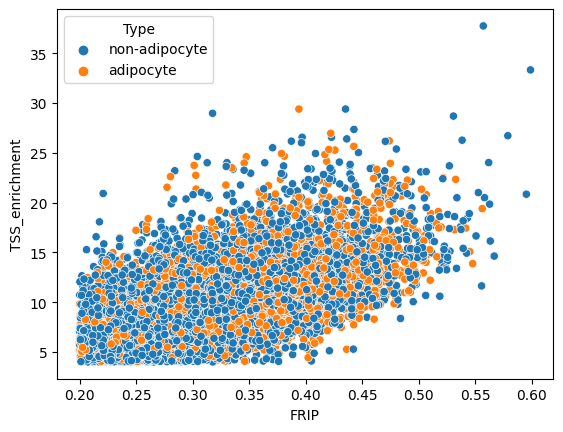

In [142]:
sns.scatterplot(cistopic_obj.cell_data, x='FRIP',y='TSS_enrichment',hue='Type')

<AxesSubplot: xlabel='Type', ylabel='TSS_enrichment'>

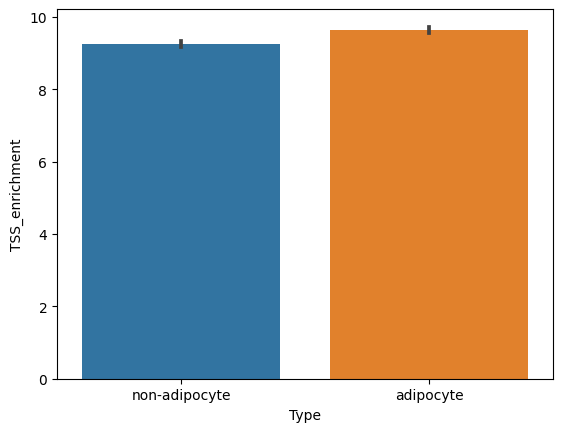

In [153]:
sns.barplot(cistopic_obj.cell_data, x='Type',y='TSS_enrichment')

In [ ]:
from pycisTopic.lda_models import *

ray.shutdown()
niterations = 400
topics = [5, 10, 15, 20, 25, 30, 35, 40, 45,  50, 55, 60, 65, 70]
mallet='/data/leuven/343/vsc34389/jupyter/envs/pycisTopic/bin/mallet'
#models=run_cgs_models(cistopic_obj_noDBL,
#                    n_topics=topics,
#                    n_cpu=4,
#                    n_iter=niterations,
#                    random_state=555,
#                    alpha=50,
#                    alpha_by_topic=True,
#                    eta=0.1,
#                    eta_by_topic=False,
#                    save_path=None)

models=run_cgs_models_mallet(mallet,
                    cistopic_obj_noDBL,
                    n_topics=[2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70],
                    n_cpu=6,
                    n_iter=500,
                    random_state=555,
                    alpha=50,
                    alpha_by_topic=True,
                    eta=0.1,
                    eta_by_topic=False,
                   # tmp_path=tmpDir + 'tmp/mallet/tutorial/', #Use SCRATCH if many models or big data set
                    save_path=None)#tmpDir + 'tmp/mallet/tutorial/')